In [1]:
import sys

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict
from effdet.efficientdet import HeadNet

In [2]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [3]:
DATA_ROOT_PATH = 'global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
dataset = DatasetRetriever(
    image_ids=np.array([path.replace('\\', '/').split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [5]:
import effdet
import importlib
importlib.reload(effdet)

def load_net(checkpoint_path):
    config = effdet.get_efficientdet_config('tf_efficientdet_d2')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = effdet.efficientdet.HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = effdet.DetBenchPredict(net, config)
    net.eval();
    return net.cuda()

net = load_net('effdet-d2-wheat/best-checkpoint-002epoch.bin')

In [6]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        img_scale = torch.tensor([1]*images.shape[0]).float().cuda()
        img_size = [image.shape[-2:] for image in images]
        img_size = torch.tensor(img_size).float().cuda()
        det = net(images, img_scale, img_size)
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

K:\Anaconda3\envs\efficientdet-pytorch\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
K:\Anaconda3\envs\efficientdet-pytorch\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
K:\Anaconda3\envs\efficientdet-pytorch\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
K:\Anaconda3\envs\efficientdet-pytorch\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you 

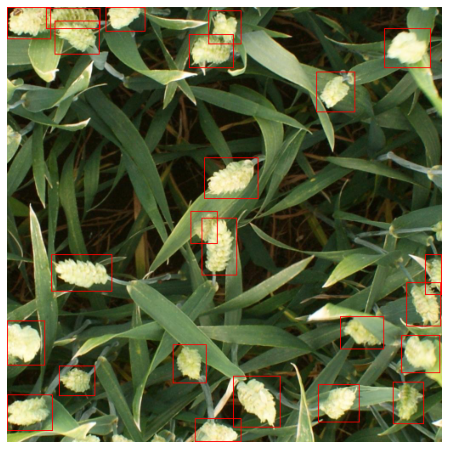

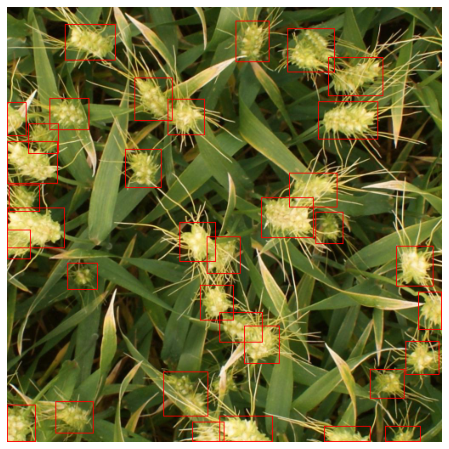

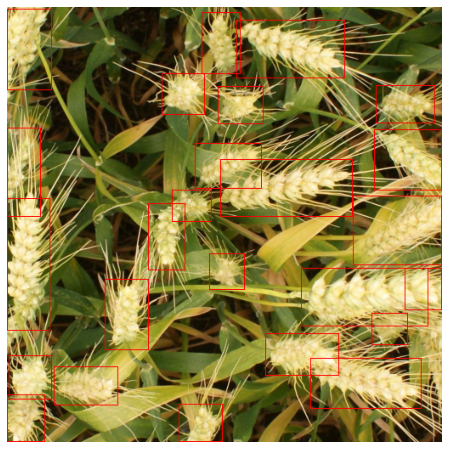

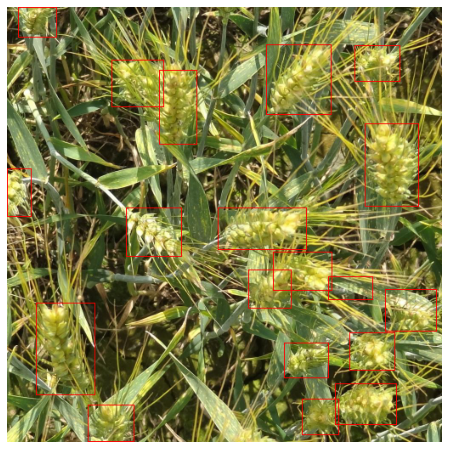

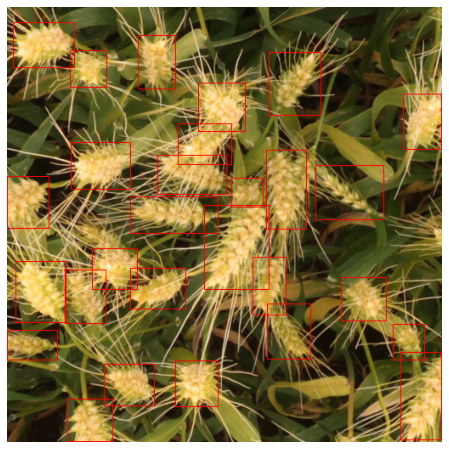

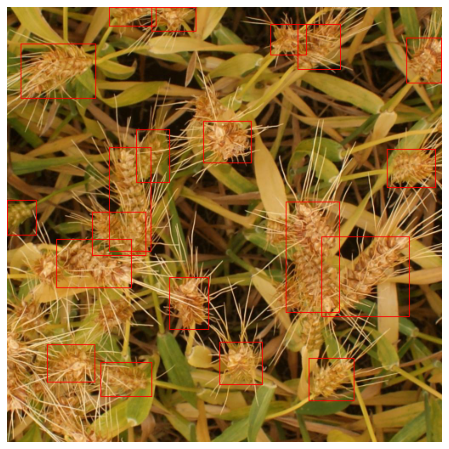

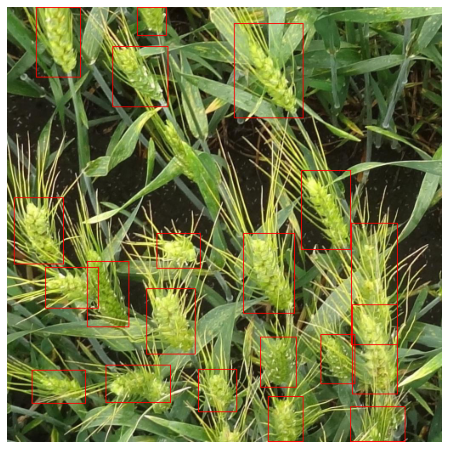

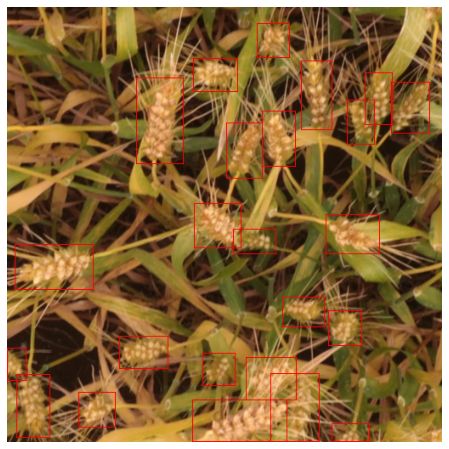

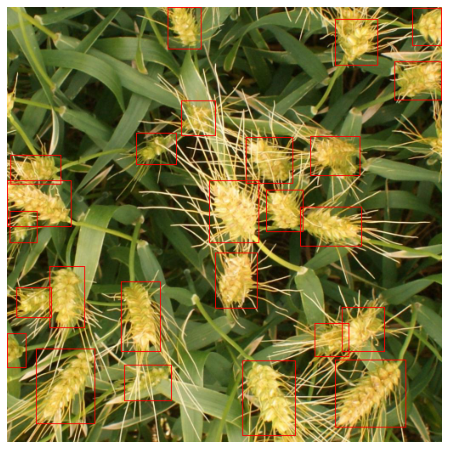

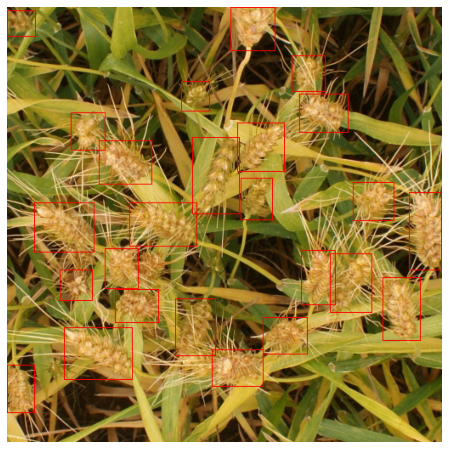

In [7]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images)
    for i, sample in enumerate(images):
        sample = sample.permute(1,2,0).cpu().numpy()

        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=511)

        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

        for box in boxes:
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

        ax.set_axis_off()
        ax.imshow(sample);